#### Install dependencies
I use the official Neo4j python driver and [Pillow](https://pillow.readthedocs.io/en/stable/) - Python Imaging Library

import sys
!{sys.executable} -m pip install neo4j
!{sys.executable} -m pip install --upgrade Pillow

In [7]:
from pathlib import Path
from PIL import Image
from PIL import ImageStat
from PIL import ImageOps
from neo4j import GraphDatabase
from numpy import dot
from numpy.linalg import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import random

current_directory = Path.cwd()

#### Load all the images and show them
The images are simple grayscale images

In [8]:
def loadImage(image_path):
    # Read the image
    return Image.open(image_path)

In [9]:
def thresholdImage(image):
    stat = ImageStat.Stat(image)
    # get the average value of the pixels
    mean = stat.mean
    # get the pixels as a numpy array
    pixels = np.array(image)
    # simple treshold using the average value of the pixels
    pixels[pixels >= mean] = 255
    pixels[pixels < mean] = 0
    # show the thresholded image
    th_image = Image.fromarray(pixels)
    
    return pixels

In [10]:
def shrinkMatrix(matrix):
    return np.matrix(matrix).getA1()

In [11]:
def resize(image, factor=0.5):
    return ImageOps.scale(image, factor, resample=Image.LANCZOS)

In [12]:
def toNetworkPattern(array):
    pattern = []
    for i in range(0,len(array)):
        if array[i] == 0:
            pattern.append(-1)
        if array[i] == 255:
            pattern.append(1)
    #pattern[pattern == 0] = -1
    #pattern[pattern == 255] = 1
    
    return pattern

In [13]:
def networkPatternToThresholdedImage(pattern, width=60, height=80):
    image = []
    # restore to 0-255 values
    for i in range(0,len(pattern)):
        if pattern[i] == 1:
            image.append(255)
        if pattern[i] == -1:
            image.append(0)
    #image[image == 1] = 255
    #image[image == -1] = 0
    
    # reshape to a proper matrix
    image = np.array(image.copy()).reshape((height,width))
    #image = Image.fromarray(image,'L')
    
    return image

In [14]:
update_state_query = """
    WITH $pattern as training_pattern
    WITH apoc.coll.shuffle(range(1, size(training_pattern), 1)) as is, training_pattern
    UNWIND is as i
    WITH i, training_pattern
    MATCH (n1:Neuron {id: i})-[r]-(n2:Neuron)
    WITH n1, sum(r.weight * n2.state) as sum
    SET n1.oldState = n1.state, n1.state = CASE WHEN sum >= 0 THEN 1 ELSE -1 END
    RETURN n1.id, n1.oldState, n1.state
"""

check_stable_state_query = """
    MATCH (n:Neuron)
    WHERE n.state <> n.oldState
    RETURN count(n.id) as count
"""

get_output_query = """
    MATCH (n:Neuron)
    WITH n order by n.id asc
    RETURN collect(n.state) as output
"""

def retrieve_image(pattern, original_pattern, max_iterations=100):
    # All neurons at the beginning are not stable
    not_stable_neurons = len(pattern)
    iterations = 1
    with driver.session() as session:
        while not_stable_neurons > 0 and iterations < 10:
            # update the state of each neuron
            session.run(update_state_query, {'pattern': pattern})
            # check if all the neurons are stable
            result = session.run(check_stable_state_query)
            for record in result:
                not_stable_neurons = record["count"]
            print("Iteration %s not stable neurons are %s" % (iterations, not_stable_neurons))
            iterations = iterations + 1
            
            result = session.run(get_output_query)
            for record in result:
                output = record["output"]
                similarity = (dot(output, original_pattern)/(norm(output)*norm(original_pattern)))
                print("Similarity {:,} at iteration %s".format(similarity) % (iterations - 1))

        #result = session.run(get_output_query)
        #for record in result:
                output = record["output"]
                outputImage = networkPatternToThresholdedImage(output)
                plt.figure(figsize=(8, 8))
                plt.imshow(outputImage, cmap='gray', vmin=0, vmax=255)

In [15]:
def random_noise(image, perc=0.2):
    noisy_image = []
    
    for i in range(0, len(image)):
        row = image[i]
        noisy_row = []
        for j in range(0, len(row)):
            rand = random.random()
            if rand <= perc:
                if row[j] == 255:
                    noisy_row.append(0)
                else:
                    noisy_row.append(255)
            else:
                noisy_row.append(row[j])
        
        noisy_image.append(noisy_row)
            
    return noisy_image

In [16]:
def crop(image, factor=0.5):
    cropped_image = []
    
    # Crop the right side of the image
    for i in range(0,len(image)):
        row = image[i]
        start = int(len(row) * 0.5)
        # take the right side of the array and set all the values to 1 (255)
        row[start:]=255
        cropped_image.append(row)
        
    plt.figure(figsize=(8, 8))
    plt.imshow(cropped_image, cmap='gray', vmin=0, vmax=255)
        
    return cropped_image

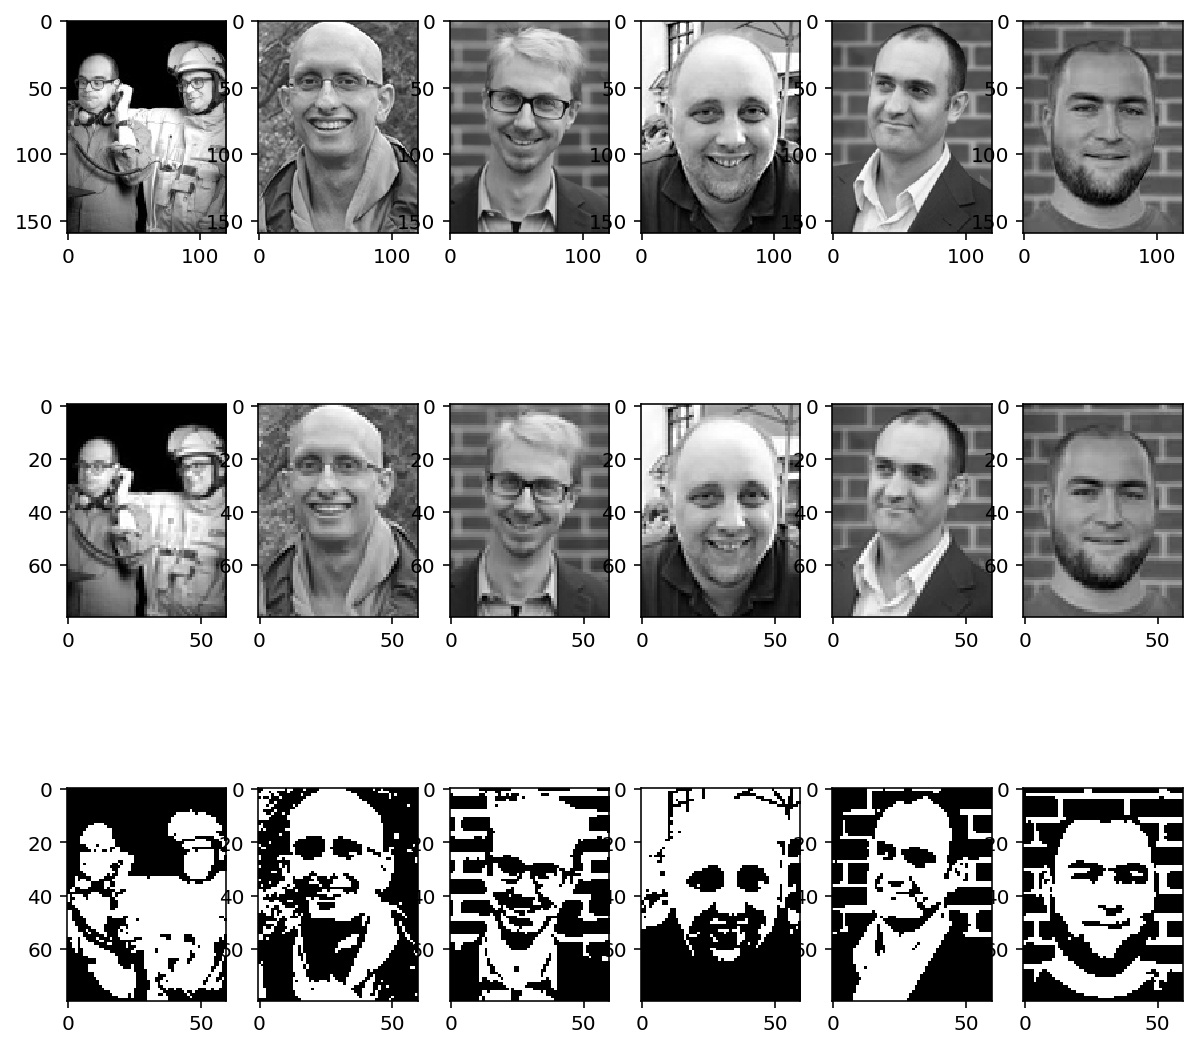

In [19]:
patterns = []

image_paths = Path(current_directory.joinpath('images/')).glob('*.jpg')
image_list = list(image_paths)

%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(10, 10))
i = 0
for image_path in image_list:
    # load the image
    image = loadImage(image_path)
    # and show it
    ax1 = ax[0][i]
    ax1.imshow(image, cmap='gray', vmin=0, vmax=255)
    
    # resize the image
    resized_image = resize(image, 0.5)
    # and show it
    ax2 = ax[1][i]
    ax2.imshow(resized_image, cmap='gray', vmin=0, vmax=255)
    
    # threshold the image
    thresholded_image = thresholdImage(resized_image)
    # and show it
    ax3 = ax[2][i]
    ax3.imshow(thresholded_image, cmap='gray', vmin=0, vmax=255)
    
    array = shrinkMatrix(thresholded_image)
    patterns.append(toNetworkPattern(array))
    i = i + 1
    
plt.show()

#### Resize images
The orginal images are 120px wide and 160px high. The size of the array representing an image is 120x160 = 19,200. In order to have a small neural network I reduce the dimension of the images up to 50% (60x80 = 4,800).
Here is an example for the last image (the non-human Michael Hunger :D)

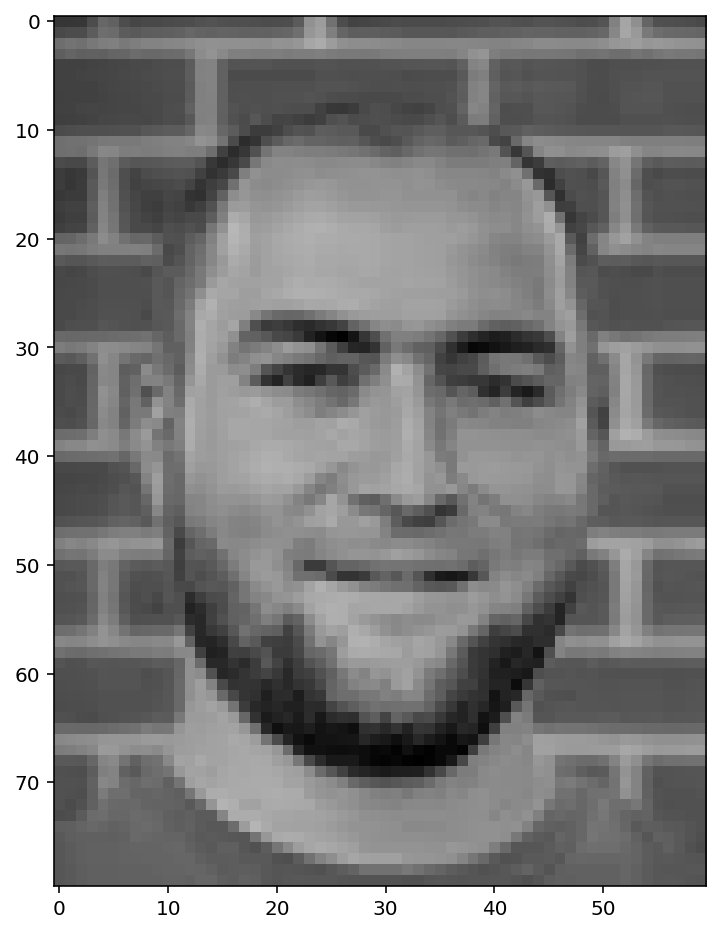

In [20]:
plt.figure(figsize=(8, 8))
michael_hunger = current_directory.joinpath('images/headshot-michael-hunger.jpg')
resized_image = resize(Image.open(michael_hunger), 0.5)
plt.imshow(resized_image, cmap='gray', vmin=0, vmax=255)

#### Convert images to white & black
I do a simple threshold processing to each image. I take the average value of the pixels as documented [here](https://pillow.readthedocs.io/en/stable/reference/ImageStat.html). Each pixel value that is lower than the average will be set to 0 while each pixel value that is higher than the average value will be set to 255.

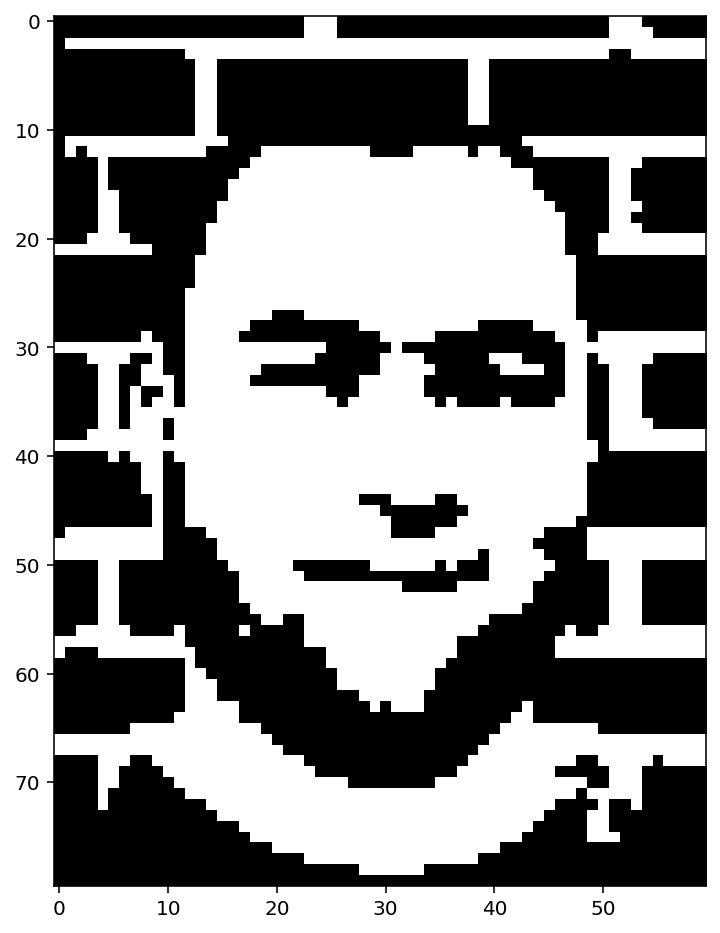

In [21]:
plt.figure(figsize=(8, 8))
thresholded_image = thresholdImage(resized_image)
plt.imshow(thresholded_image, cmap='gray', vmin=0, vmax=255)
#array = shrinkMatrix(matrix)

#### Store the images in the Hopfield network
The model of the this network uses a variation of classic McCulloch and Pitts neuron. It's the first computational model of a neuron that was proposed by Warren MuCulloch (neuroscientist) and Walter Pitts (logician) in 1943. It takes inspiration from the biological neuron: there are the dendrites that take inputs from other neurons, the soma processing the inputs and then the output is propagated through the axon (and then to the synapses, the point of contact with other neurons). A McCulloch and Pitts neuron is composed by two parts:

The first one is the sum of all the inputs coming from the other neurons (through the synapses):

\begin{equation*} X = (x_1, x_2, ... , x_N) \quad \quad g(X) = \sum_{i=1}^N x_i \end{equation*}

The second part is the processing function of the inputs (let say that the function _g_ is the soma):

\begin{equation*} f(g(X)) = 1 \quad \text{if } g(X) >= \Theta \\ f(g(X)) = 0 \quad \text{if } g(X) < \Theta \end{equation*}

Where theta is the threshold.

This model is the simplest we can use to build a neural network but we need learning rule, that is a way to evolve the weights of the connections between the neurons and the state of each neuron as well. If we have a connection that starts from the neuron A and ends to the neuron B than the input for B will be the product of A's output by the weight of the connection between A and B. 

One of the most famous learning rules is the Hebbian rule. Hebb’s rule is a postulate proposed by Donald Hebb in 1949 and describes how the neuronal activities influence the connection between neurons. The classical Hebb’s rule indicates “neurons that fire together, wire together”. This means that the connections between two neurons might be strengthened if the neurons fire simultaneously. The Hebbian Rule works well as long as all the input patterns are orthogonal or uncorrelated. The requirement of orthogonality places serious limitations on the Hebbian Learning Rule.

The Hopfield model is an associative memory model using the Hebb’s rule. The learning rule for this model is described by the following equation:

\begin{equation*}
w_{ij} = \frac{1}{N} \sum_{\mu=1}^P x_i^\mu x_j^\mu
\end{equation*}

##### Store the pattern into Neo4j
Here is the cypher queries to create the Hopfield network and learn the pattern using the Hebbian rule

In [22]:
number_of_nodes = len(patterns[0])
print("Number of nodes (size of one pattern): {:,}".format(number_of_nodes))

uri = "neo4j://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "password"), encrypted=False)

create_network_neurons = """
    WITH $patterns as patterns
    WITH size(patterns[0]) as numOfNodes
    // Generate a Hopfield Network with N perceptrons (neurons) and NxN connections
    UNWIND range(1, numOfNodes) as id
    MERGE (n:Neuron {id: id})
    RETURN count(n)
"""

init_weights_query = """
    CALL apoc.periodic.iterate(
        'WITH $patterns as patterns
        UNWIND patterns as pattern
        WITH range(1, size(pattern)) as is, range(1, size(pattern)) as js, pattern
        UNWIND is as i
        UNWIND js as j
        WITH i, j, pattern
        WHERE j > i
        WITH sum(pattern[i-1] * pattern[j-1]) / (1.0 * size(pattern)) as w_ij, i, j
        MATCH (n1:Neuron {id: i})
        MATCH (n2:Neuron {id: j})
        RETURN n1, n2, w_ij',
        'MERGE (n1)-[connection:CONNECTED_TO]->(n2)
        SET connection.weight = w_ij
        RETURN n1.id, connection.weight, n2.id',
        { batchSize: 500, parallel: false, params: {patterns:$patterns} }
    ) YIELD batch, operations
    RETURN batch, operations
"""

with driver.session() as session:
    # create the network
    # session.run("CREATE INDEX neuron_id FOR (n:Neuron) ON (n.id)")
    #session.run(create_network_neurons, {"patterns": patterns})
    #session.run(init_weights_query, {"patterns": patterns})
    result = session.run("MATCH (n:Neuron) RETURN count(n) as neurons")
    for record in result:
        print("Number of total nodes: {:,}".format(record["neurons"]))
    result = session.run("MATCH (:Neuron)-[r:CONNECTED_TO]->(:Neuron) RETURN count(r) as connections")
    for record in result:
        print("Number of total connections: {:,}".format(record["connections"]))

Number of nodes (size of one pattern): 4,800
Number of total nodes: 4,800
Number of total connections: 11,517,600


According to the Hebbian rule, for a given pattern $\mu$, if two element $x^{\mu}_i$ and $x^{\mu}_j$ are equals than for the neurons $i$ and $j$ the product $x_i^\mu x_j^\mu$ will be positive otherwise the value will be negative. Let's take the first neuron $i = 1$ and five neighbours of $i$ where $w_{ij} < 0$. We expect that most of the values $\mu_i$ and $\mu_j$ (the pixels in our patterns) will not have the same sign.

Let's see an example:

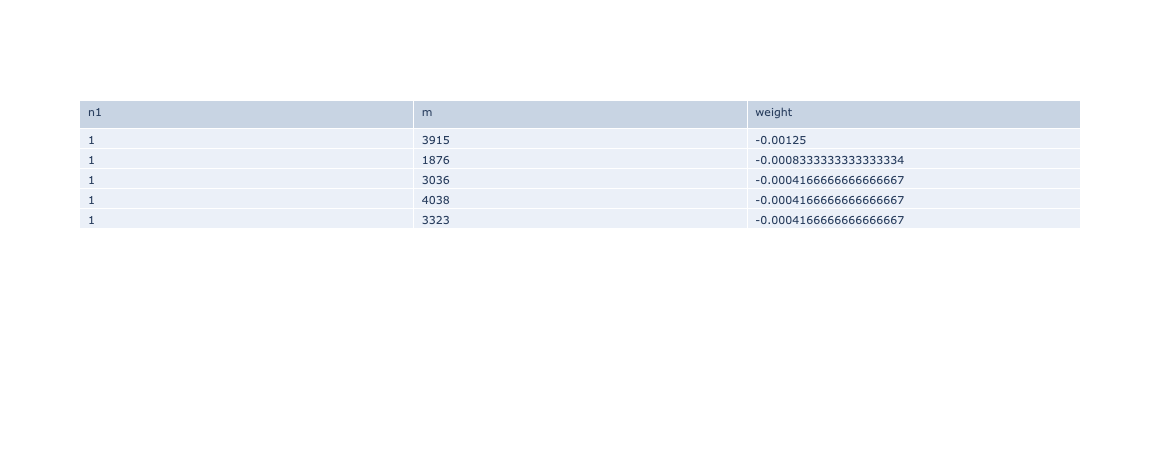

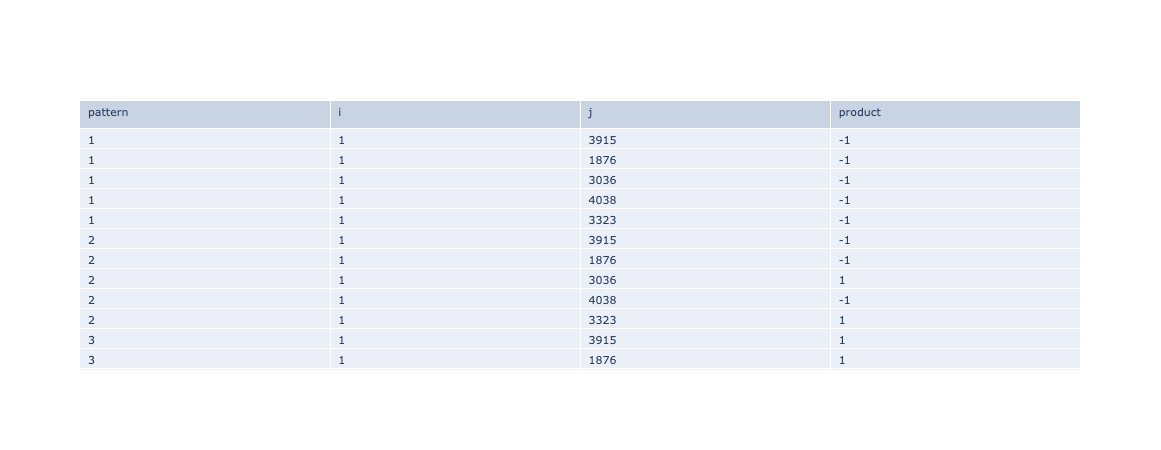

In [27]:
with driver.session() as session:
     # Get some neurons that are out of sync, they don't fire together
    result = session.run("MATCH p=(n:Neuron)-[r:CONNECTED_TO]->(n2:Neuron) WHERE r.weight < 0 RETURN n.id as n1, n2.id as m, r.weight as weight LIMIT 5")
    df = pd.DataFrame(result.records(), columns=result.keys())
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df.columns),align='left',font_size=11),
        cells=dict(values=[df.n1, df.m, df.weight],align='left',font_size=11))
    ])
fig.show()

df2 = pd.DataFrame(columns=['pattern','i','j','product'])
mu = 1
for p in patterns:
    # get the n element of the pattern that is the n neuron of the network
    dataframe_array = df.to_numpy() 
    for i in range(0, len(dataframe_array)):
        index1 = int(df.to_numpy()[i][0])
        index2 = int(df.to_numpy()[i][1])
        product = p[index1] * p[index2]
        df2 = df2.append({'pattern':mu,'product':product, 'i':index1, 'j':index2}, ignore_index=True)
    mu = mu + 1

fig2 = go.Figure(data=[go.Table(
    header=dict(values=list(df2.columns),align='left',font_size=11),
    cells=dict(values=[df2.pattern,df2['i'],df2['j'],df2['product']],align='left',font_size=11))
])
fig2.show()

As you can see most of the values are negative. As you can see Neo4j let you investigate the structure of the neural network and explore out the connections change and are updated. Neural networks work like a black box but having the entire network in a graph database let us understand what happens under the hood.

Let's try to ask the network to retrieve one of the previous pattern. If someone shows me a picture of Michael Hunger I will retrieve it from my memory. 

How can we achive this with the Hopfield network? Our neurons are both the input layer and the output layer of the neural network. What we need to do is to set the initial state of our neurons according to the values of our pattern (the pattern we want to retrieve) and then apply the Hebbian rule to update the states of the neurons.

In [324]:
init_pattern_query = """
    WITH $pattern as training_pattern
    UNWIND range(1, size(training_pattern), 1) as index
    MATCH (n:Neuron {id: index})
    SET n.state = training_pattern[index]
    SET n.oldState = 0
"""

micheal_hunger_pattern = patterns[5]

with driver.session() as session:
    session.run(init_pattern_query, {'pattern': micheal_hunger_pattern})

#### Retrieve a stored image

Let's try to retrieve a previously stored image. We just only set the input of our network and then iterate until convergence. After we reach a stable state we get the state of each neuron back and convert back to a matrix with 80 rows and 60 columns (and 0 or 255 values). We also check the similarity between the original input and the network output.

Iteration 1 not stable neurons are 0
Similarity 0.9999999999999998 at iteration 1


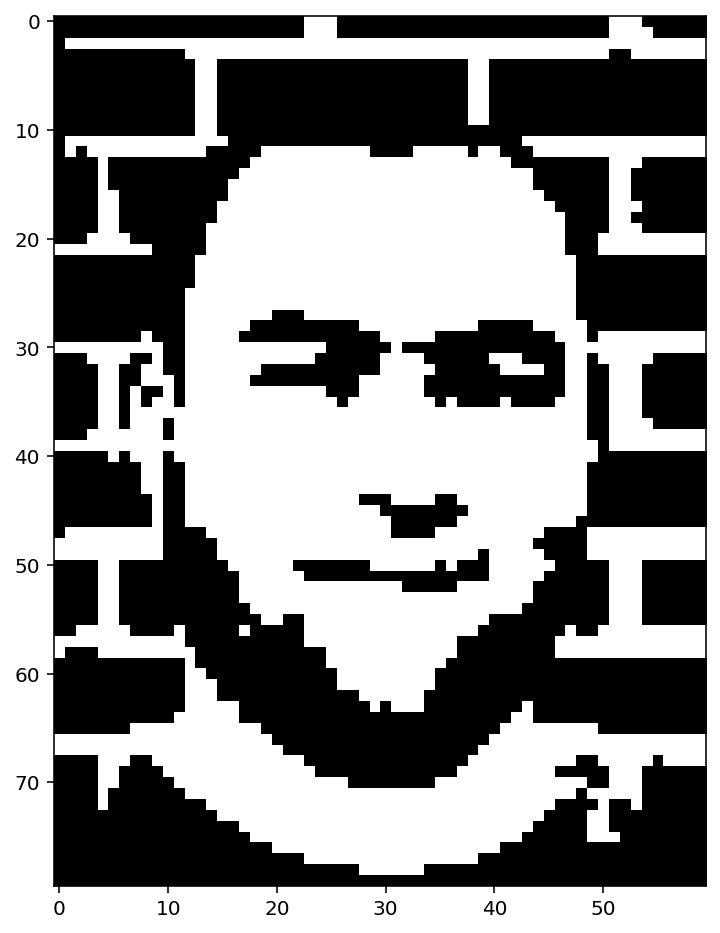

In [337]:
retrieve_image(micheal_hunger_pattern, micheal_hunger_pattern)

#### Retrieve a stored image from a partial one

Let's try to retrieve a previously stored image but the input will be a partial image of the original one. I want to see if the network will be able to retrieve the original image with a cropped version of it. 

I take the original image and will set all the pixels of the right half to white and I will use this new modified image as the input of the network. Then I will iterate until convergence.

Iteration 1 not stable neurons are 1460
Similarity 0.9529166666666665 at iteration 1
Iteration 2 not stable neurons are 113
Similarity 0.9999999999999998 at iteration 2
Iteration 3 not stable neurons are 0
Similarity 0.9999999999999998 at iteration 3


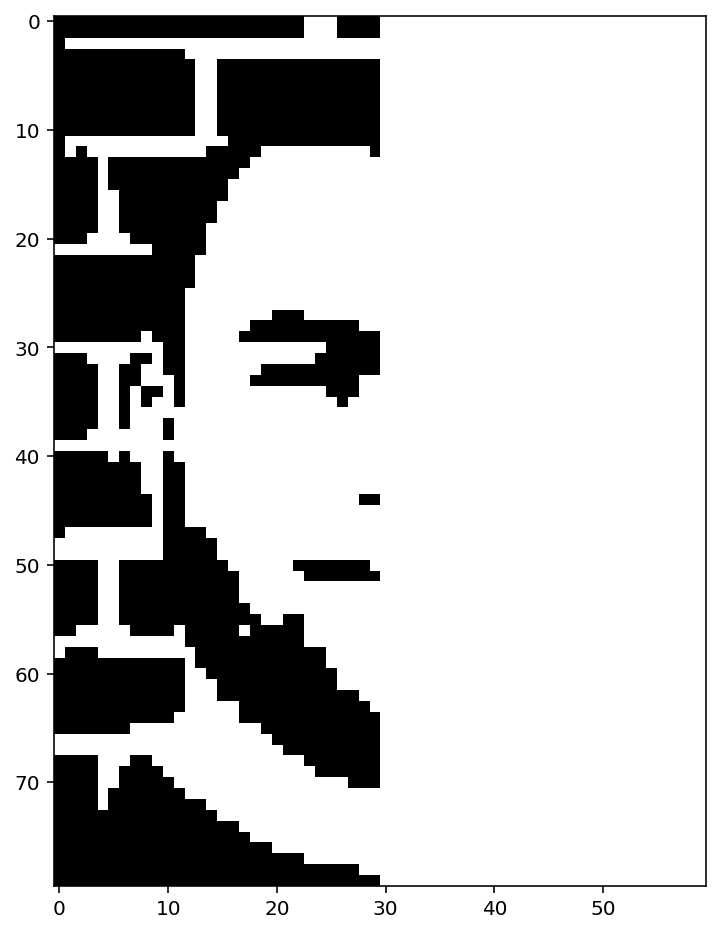

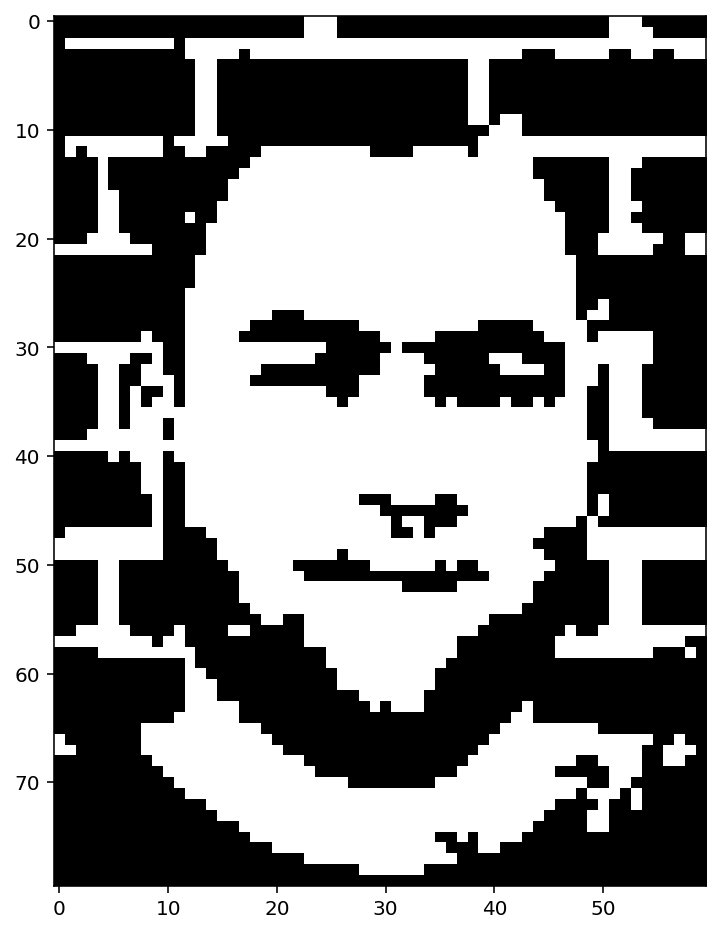

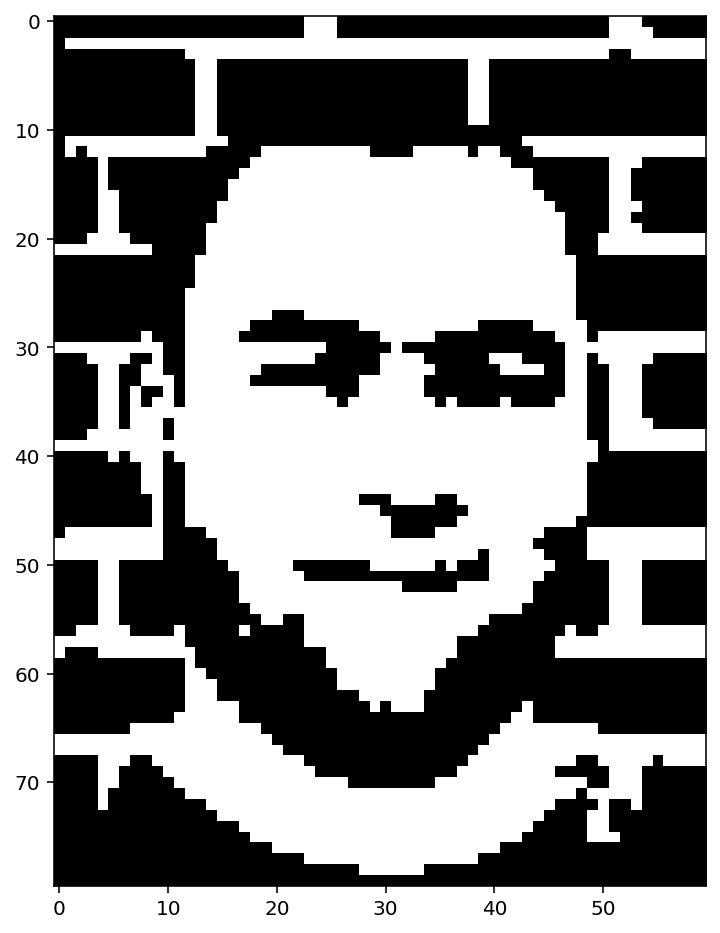

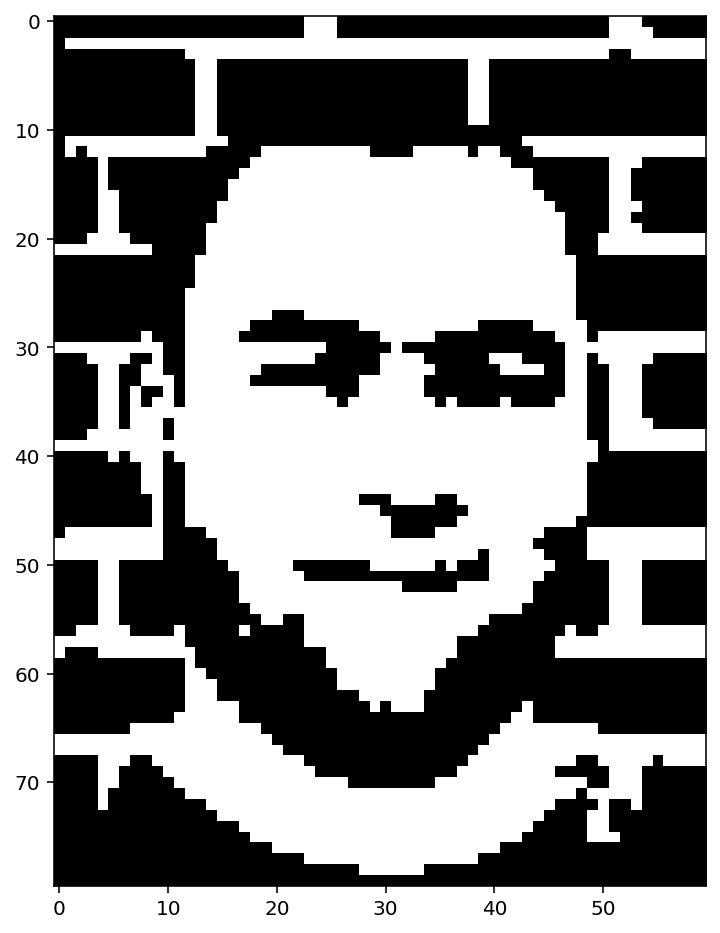

In [360]:
thresholded_image = thresholdImage(resized_image)
#cropped_image = Image.frombytes("L", (thresholded_image.shape[1], thresholded_image.shape[0]), thresholded_image.tostring())
#cropped_image = cropped_image.crop(box=(0, 0, 30, 80))
#plt.figure(figsize=(8, 8))
#plt.imshow(cropped_image, cmap='gray', vmin=0, vmax=255)

# Crop the right side of the image - 50%
cropped_image = crop(thresholded_image)
      
cropped_array = shrinkMatrix(cropped_image)  
cropped_pattern = toNetworkPattern(cropped_array)#.tolist()

with driver.session() as session:
    session.run(init_pattern_query, {'pattern': cropped_pattern})
    
retrieve_image(cropped_pattern, micheal_hunger_pattern)

I will try with just only 33% of the original image

Iteration 1 not stable neurons are 1460
Similarity 0.9529166666666665 at iteration 1
Iteration 2 not stable neurons are 113
Similarity 0.9999999999999998 at iteration 2
Iteration 3 not stable neurons are 0
Similarity 0.9999999999999998 at iteration 3


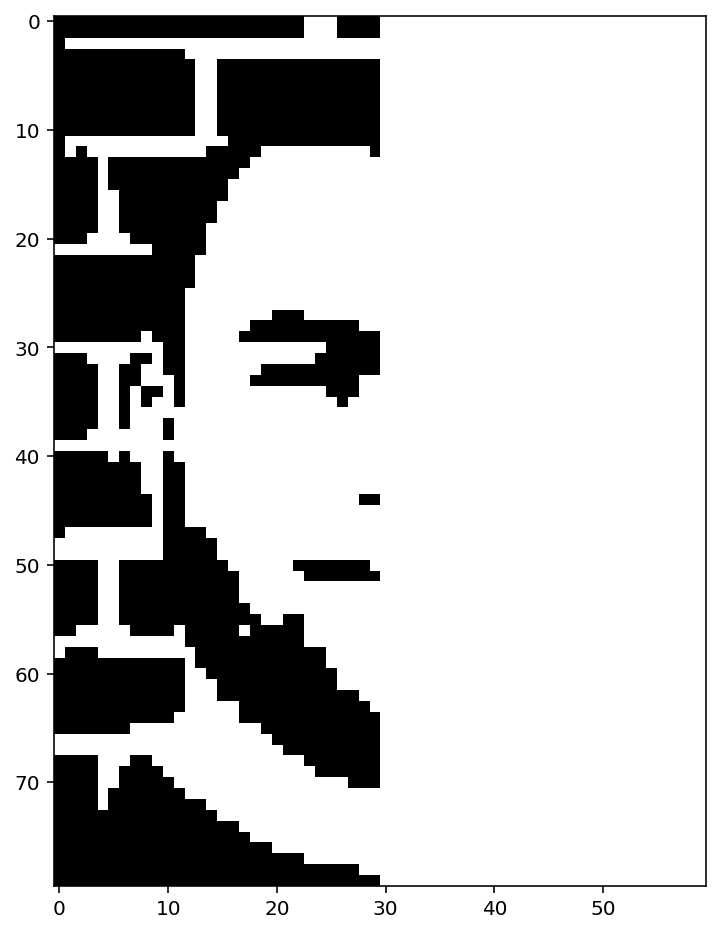

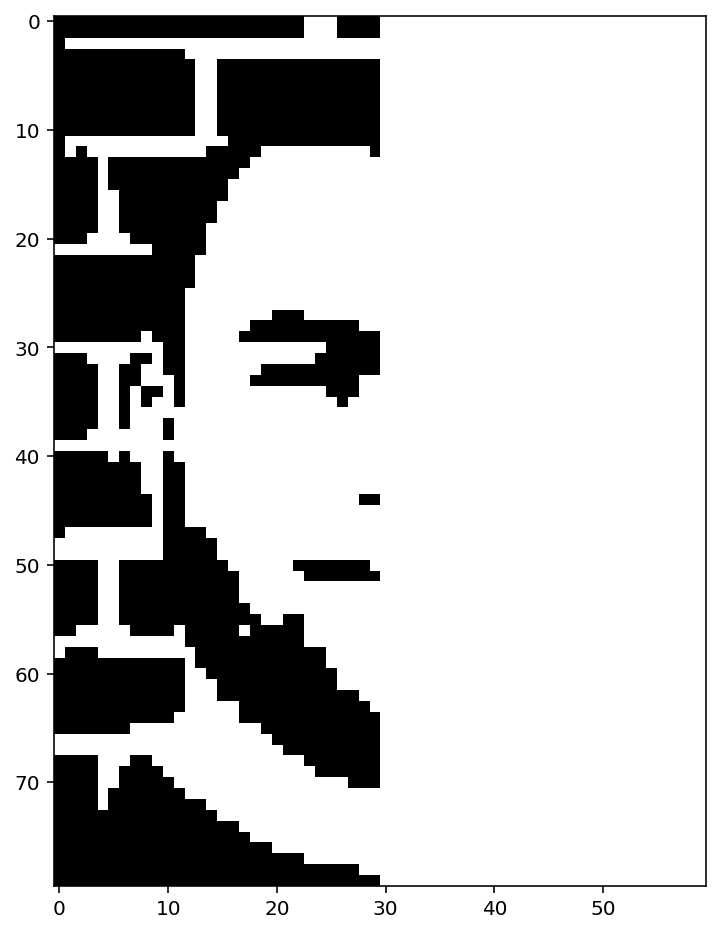

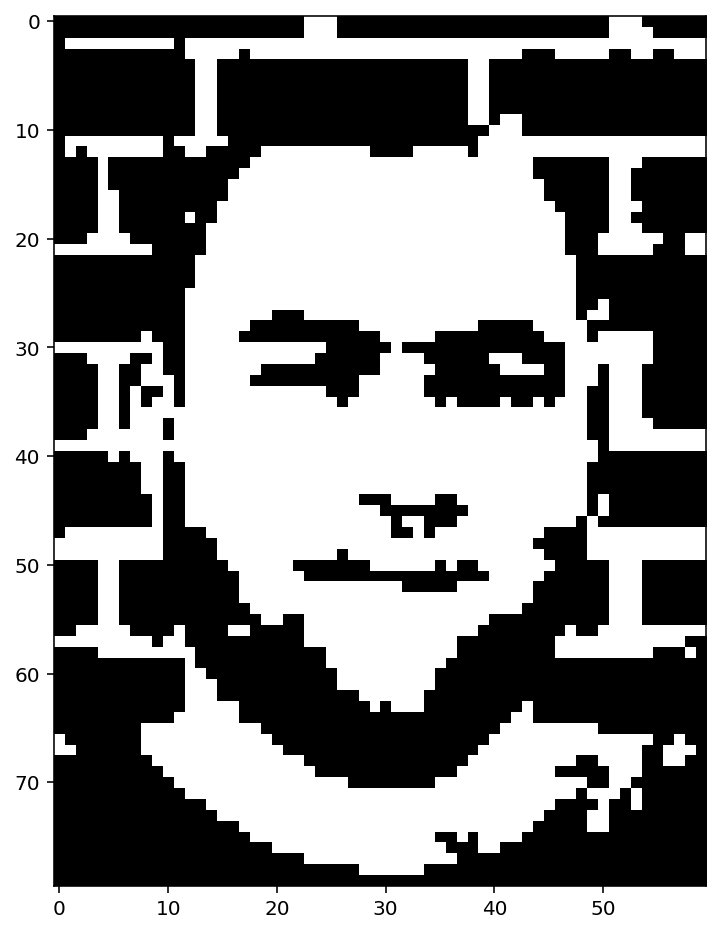

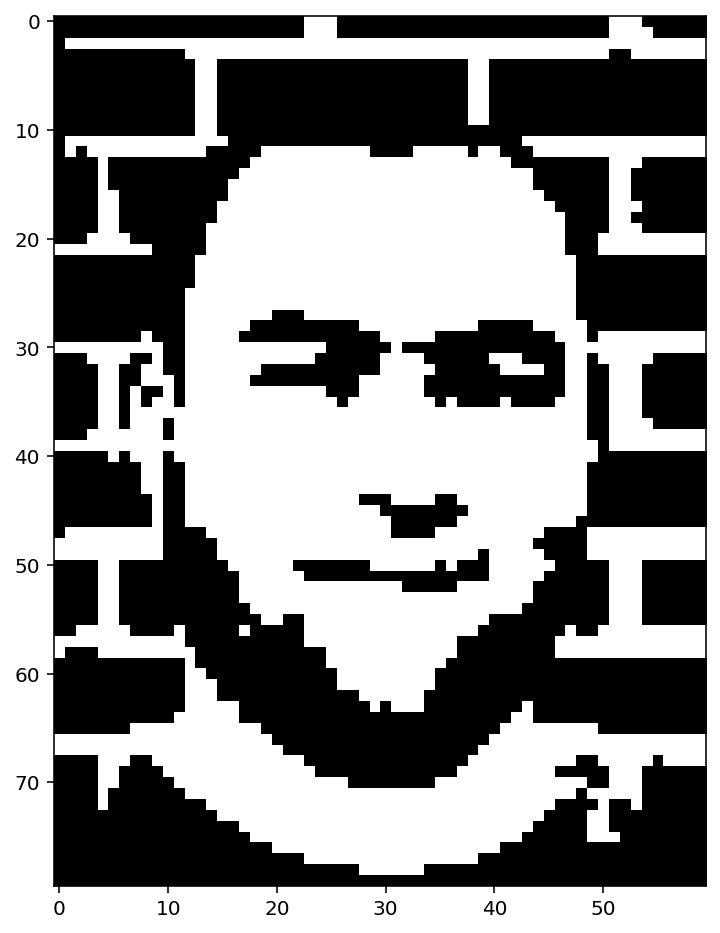

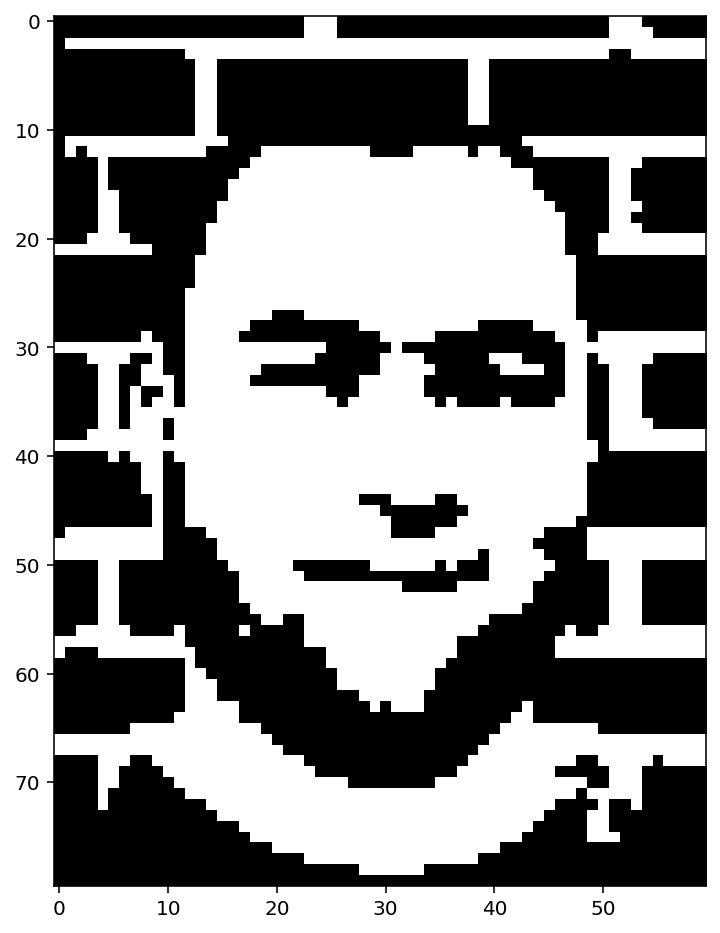

In [359]:
thresholded_image = thresholdImage(resized_image)
#cropped_image = Image.frombytes("L", (thresholded_image.shape[1], thresholded_image.shape[0]), thresholded_image.tostring())
#cropped_image = cropped_image.crop(box=(0, 0, 20, 80))
#plt.figure(figsize=(8, 8))
#plt.imshow(cropped_image, cmap='gray', vmin=0, vmax=255)

# Crop the right side of the image - 66%
cropped_image = crop(thresholded_image, 0.3)

plt.figure(figsize=(8, 8))
plt.imshow(cropped_image, cmap='gray', vmin=0, vmax=255)
      
cropped_array = shrinkMatrix(cropped_image)  
cropped_pattern = toNetworkPattern(cropped_array)

with driver.session() as session:
    session.run(init_pattern_query, {'pattern': cropped_pattern})
    
retrieve_image(cropped_pattern, micheal_hunger_pattern)

#### Retrieve a stored image from a noisy one

Let's try to retrieve a previously stored image but the input will be a noisy image of the original one. I want to see if the network will be able to retrieve the original image with a cropped version of it. 

I take the original image and I will change the value of pixels with a certain probability and I will use this new modified image as the input of the network. Then I will iterate until convergence.

Iteration 1 not stable neurons are 1211
Similarity 0.9999999999999998 at iteration 1
Iteration 2 not stable neurons are 0
Similarity 0.9999999999999998 at iteration 2


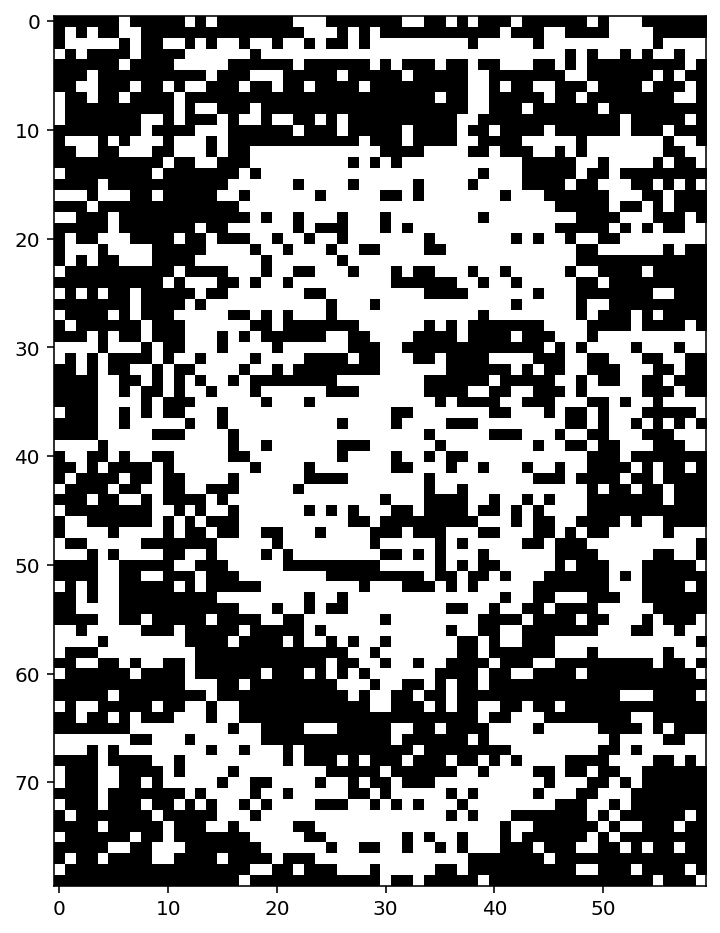

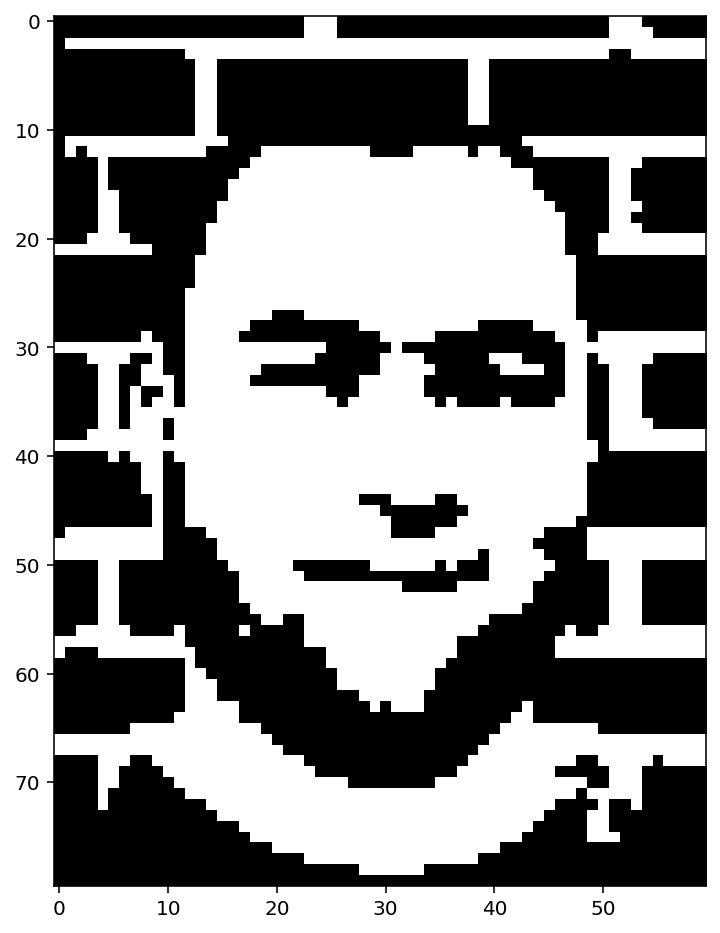

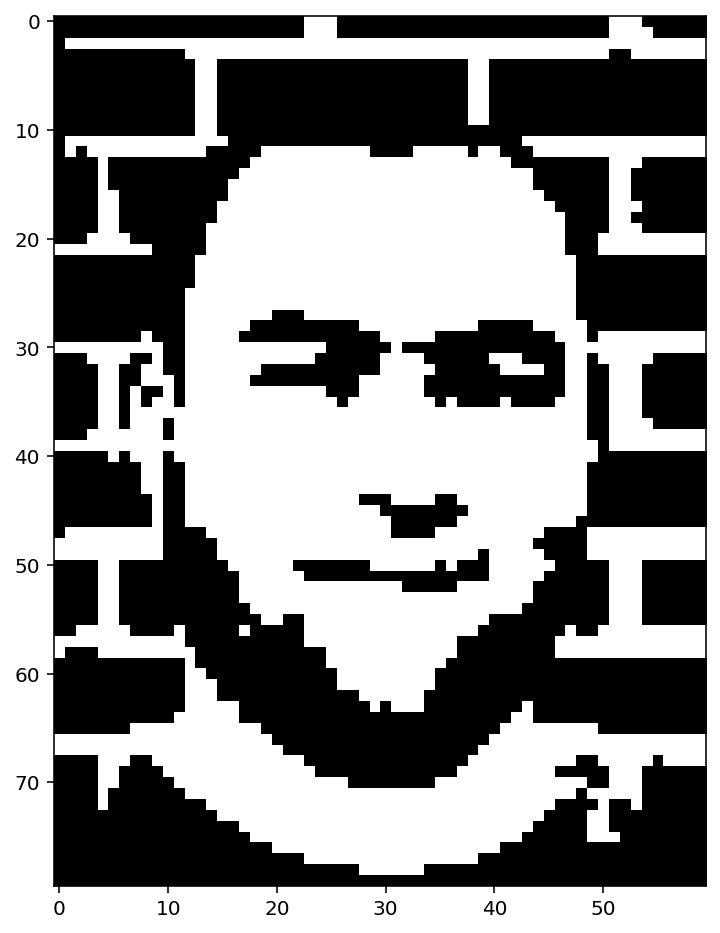

In [363]:
thresholded_image = thresholdImage(resized_image)
# 20% of the pixels will be flipped, if 255 then 0 otherwise 255
noisy_image = random_noise(thresholded_image)
plt.figure(figsize=(8, 8))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)

noisy_array = shrinkMatrix(noisy_image)  
noisy_pattern = toNetworkPattern(noisy_array)

with driver.session() as session:
    session.run(init_pattern_query, {'pattern': noisy_pattern})
    
retrieve_image(noisy_pattern, micheal_hunger_pattern)

#### Mess the thing around

Now I want to try to reach the limit and see what happens if half of the image is corrupted by noise. But, before starting, a brief consideration. The noisy image that I will obtain with a 50% of noisy pixels is really messy and no human can understand and recall the orginal image. 

The result of the network is even more interesting because it's always Michael Hunger but a negative version of the original image. The result is not one of the original image but it's a (valid) local minimum of the energy function (of the Hopfield network). This state is called a spurious state that is something that has not been stored previously.

Iteration 1 not stable neurons are 2015
Similarity -0.9999999999999998 at iteration 1
Iteration 2 not stable neurons are 0
Similarity -0.9999999999999998 at iteration 2


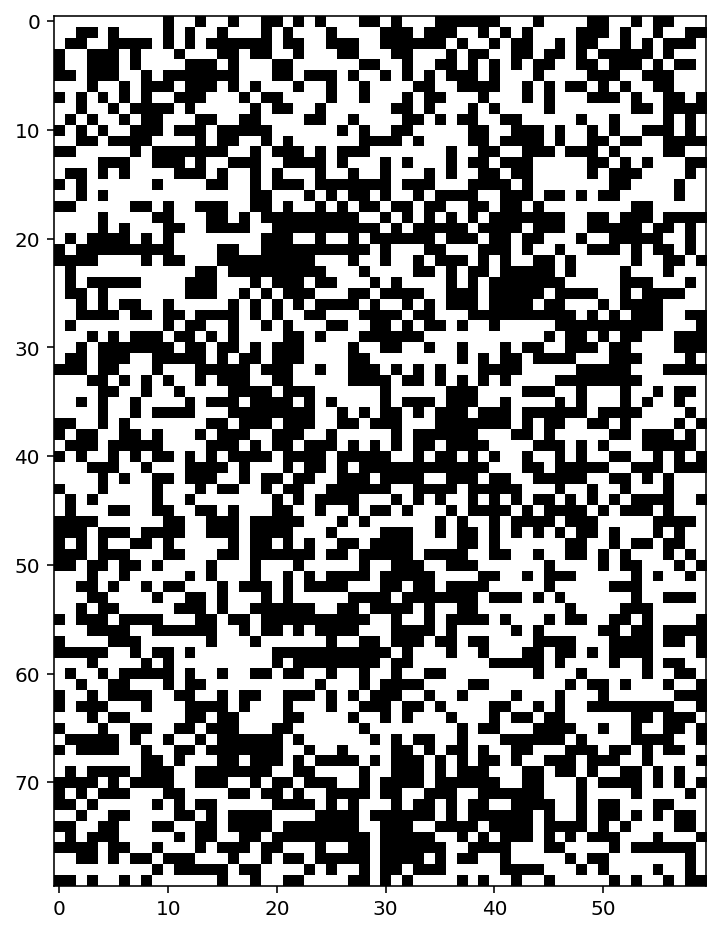

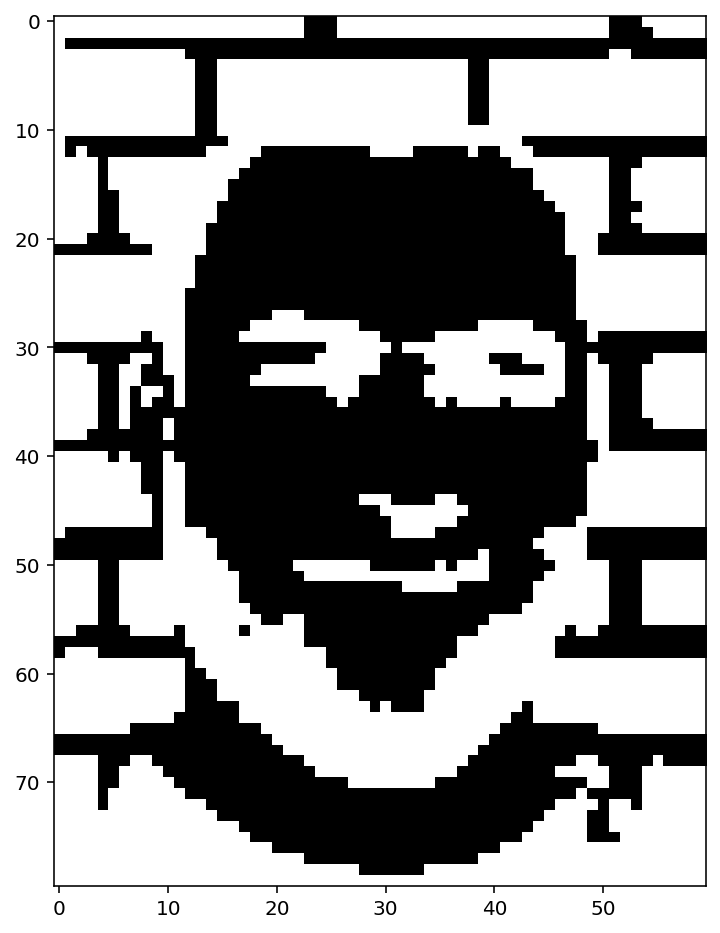

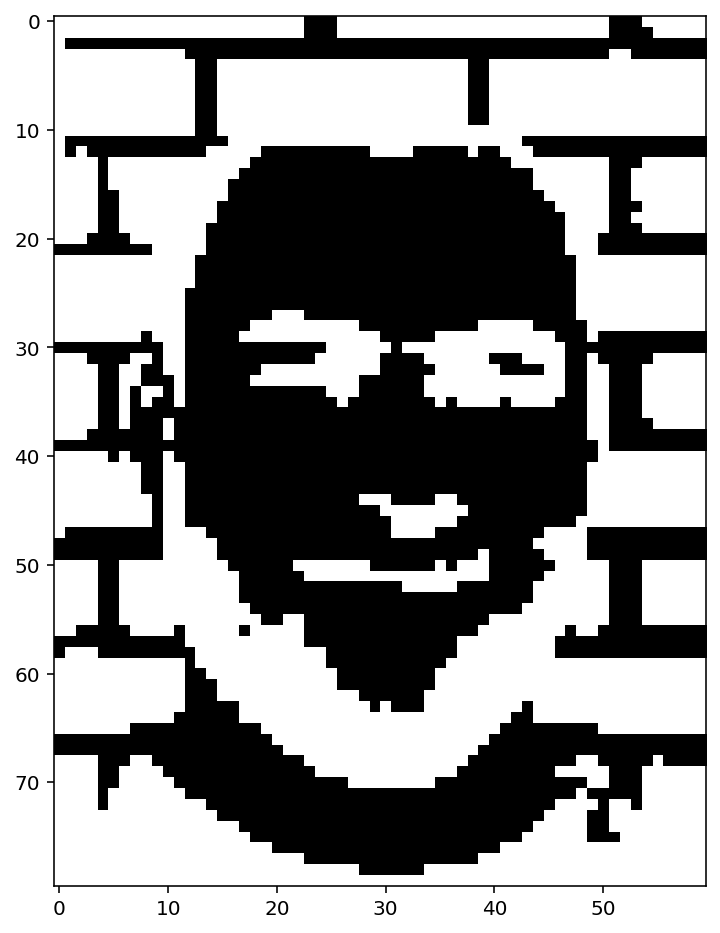

In [369]:
thresholded_image = thresholdImage(resized_image)
# 50% of the pixels will be flipped, if 255 then 0 otherwise 255
noisy_image = random_noise(thresholded_image, 0.6)
plt.figure(figsize=(8, 8))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)

noisy_array = shrinkMatrix(noisy_image)  
noisy_pattern = toNetworkPattern(noisy_array)

with driver.session() as session:
    session.run(init_pattern_query, {'pattern': noisy_pattern})
    
retrieve_image(noisy_pattern, micheal_hunger_pattern)